<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB
area_type
Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: count, dtype: int64
********************
availability
Ready To Move    10581
18-Dec             307
18-May             295
18-Apr             271
18-Aug             200
                 ...  
15-Aug               1
17-Jan            

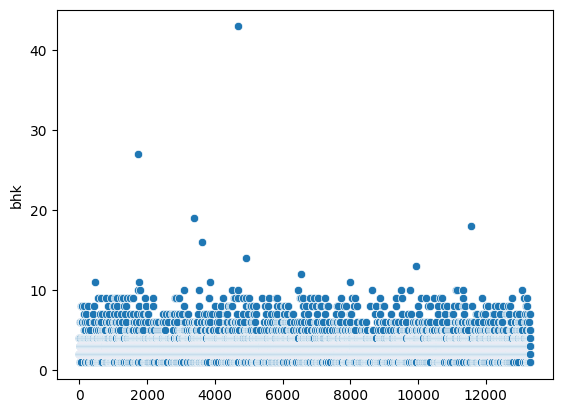

In [443]:

import numpy as np
import pandas as pd

data=pd.read_csv("/home/illahi/Desktop/Bengaluru_House_Data.csv")


data.sample(4)

data.shape

data.info()

for i in data.columns:
    print(data[i].value_counts())
    print("*"*20)

data.isnull().sum()

data.drop(columns=["area_type","society","balcony","availability"],inplace=True)

data.describe()

data.info()

for i in data.columns:
    print(data[i].value_counts())
    print("_"*40)

data['location']=data["location"].fillna("Sarjapur Road")

data['location'].isnull().sum()

data['size']=data['size'].fillna(16)

data['size'].isnull().sum()

data['bath']=data['bath'].fillna(data['bath'].median())



data['bhk']=data['size'].str.split().str.get(0)
# data['size'].isnull().sum()

data['bhk']=pd.to_numeric(data['bhk'])

data.info()

import matplotlib.pyplot as plt
import seaborn as sns

# sns.kdeplot(data['bhk'])
sns.scatterplot(data['bhk'])

data[data["bhk"]>20]

data["total_sqft"].unique()

# data.head(50)
def convertRange(x):
    temp=x.split('-')
    if(len(temp)==2):
        return (float(temp[0])+float(temp[1]))/2
    try:
        return float(x)
    except:
        return None
    # if(len(temp)!=2):
    #     return float(x)
    # else:
    #     return (float(temp[0])+float(temp[1]))/2
    # try:
    #     return float(x)
    # except:
    #     return None

data["total_sqft"]=data["total_sqft"].apply(convertRange)

data.head(50)

data["price_per_sqft"]=np.round(data["price"]/data["total_sqft"]*100000,2)

data.head(3)
# data.drop(columns=["price per sqft"],inplace=True)

data.describe()

data["location"].value_counts()

data['location']=data["location"].apply(lambda x:x.strip())

loc=data["location"].value_counts()

locless10=loc[loc<=10]

locless10

data["location"]=data["location"].apply(lambda x: "other" if x in locless10 else x )

data["location"].value_counts()

(data["total_sqft"]/data["bhk"]).describe()
data.value_counts()

data=data[((data["total_sqft"]/data["bhk"])>=300)]
data.describe()

data.shape

data.price_per_sqft.describe()

def remove_outliers_sqft(df):
    df_output=pd.DataFrame()
    for key,subdf in df.groupby('location'):
        m=np.mean(subdf.price_per_sqft)
        s=np.std(subdf.price_per_sqft)
        gen_df=subdf[(subdf.price_per_sqft>(m-s))&(subdf.price_per_sqft<=(m+s))]
        df_output=pd.concat([df_output,gen_df],ignore_index=True)
    return df_output
data=remove_outliers_sqft(data)
data.describe()


def bhk_outlier_remover(df):
    exclude_indices=np.array([])
    for location,location_df in df.groupby('location'):
        bhk_stats={}
        for bhk,bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk]={
                'mean':np.mean(bhk_df.price_per_sqft),
                'std':np.std(bhk_df.price_per_sqft),
                'count':bhk_df.shape[0]
            }
        for bhk,bhk_df in location_df.groupby('bhk'):
            stats=bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices=np.append(exclude_indices,bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')

data=bhk_outlier_remover(data)

data.shape

data

data.drop(columns=['size','price_per_sqft'],inplace=True)

data['bhk'].value_counts()
data.to_csv('cleaned_data.csv')

X=data.drop(columns=['price'])
y=data['price']
data

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

Xtrain,Xtest,Ytrain,Ytest=train_test_split(X,y,test_size=0.2,random_state=0)

print(Xtrain.shape)
print(Xtest.shape)
col_trans=make_column_transformer((OneHotEncoder(sparse_output=False),['location']),remainder="passthrough")

lr=LinearRegression()
scaler=StandardScaler()
pipe=make_pipeline(col_trans,scaler,lr)
pipe.fit(Xtrain,Ytrain)


ypred_lr=pipe.predict(Xtest)
print(r2_score(Ytest,ypred_lr))


In [444]:
la=Lasso()
scaler=StandardScaler()
pipe=make_pipeline(col_trans,scaler,la)
pipe.fit(Xtrain,Ytrain)


ypred_la=pipe.predict(Xtest)
print(r2_score(Ytest,ypred_la))

0.8675805232902737


In [445]:
r=Ridge()
scaler=StandardScaler()
pipe=make_pipeline(col_trans,scaler,r)
pipe.fit(Xtrain,Ytrain)


ypred_r=pipe.predict(Xtest)
print(r2_score(Ytest,ypred_r))

0.8719099959489083


In [447]:
from sklearn.ensemble import VotingRegressor
est=[("lr",lr),("la",la),("r",r)]

In [448]:
v=VotingRegressor(est)

In [449]:
from sklearn.model_selection import cross_val_score

In [452]:
# score=cross_val_score(v,Xtrain,Ytrain,scoring="r2",cv=10)
# print(np.round(np.mean(score),4))
scaler=StandardScaler()
pipe=make_pipeline(col_trans,scaler,v)
pipe.fit(Xtrain,Ytrain)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['location'])])),
                ('standardscaler', StandardScaler()),
                ('votingregressor',
                 VotingRegressor(estimators=[('lr', LinearRegression()),
                                             ('la', Lasso()),
                                             ('r', Ridge())]))])

In [453]:
ypred_r=pipe.predict(Xtest)
print(r2_score(Ytest,ypred_r))

0.8732389798079062
